In [1]:
%pylab inline

import networkx as nx
import scipy.sparse
import pandas as pd
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

from regain import datasets; reload(datasets)
from regain.datasets import is_pos_def, is_pos_semidef
from regain.plot import plot_graph_with_latent_variables
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_v2_; reload(latent_time_graph_lasso_v2_)
from regain.admm import latent_time_graph_lasso_v3_; reload(latent_time_graph_lasso_v3_)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain.utils import error_norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext pymatbridge
%matlab cd /home/fede/Downloads/lvglasso-pub/
# %matlab cd /home/veronica/src/lvglasso-pub/

/home/fede/miniconda2/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-7c3fcd0a-69fe-4b9b-a3b0-1d82cb892ab2
Send 'exit' command to kill the server
........MATLAB started and connected!


In [33]:
reload(datasets)
n_samples = 200
input_dim = 100
n_dim_lat = 7
T=10


data_list, K, K_obs, ells = datasets.generate_dataset(
     mode='', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=input_dim, T=T)

In [34]:
data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

## GridSearch optimisation

In [35]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain.admm import latent_time_graph_lasso_v3_; reload(latent_time_graph_lasso_v3_);

mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1])

ltgl = GridSearchCV(mdl, dict(#tau=[0.25, 0.2, 0.1],
                             tau=np.linspace(0.01, 0.8, 20),
                             eta=[0], beta=[0],
                             #alpha=[0.05, 0.1, 1],
                             alpha=np.linspace(0.01, 0.2, 5)),
                    cv=ShuffleSplit(1, test_size=.5)).fit(data_grid)

In [36]:
emp_list = list(ltgl.best_estimator_.covariance_)
alpha = ltgl.best_params_['alpha']
beta = ltgl.best_params_['beta']
tau = ltgl.best_params_['tau']
print(tau) #0.25
print(alpha)# 0.05

0.8
0.2


In [128]:
ltgl.best_params_

{'alpha': 0.01, 'beta': 0, 'eta': 0, 'tau': 0.13473684210526318}

## Bayesian optimisation (GPyOpt)

In [7]:
# mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
#     bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
#     max_iter=500, rho=1. / np.array(data_list).shape[1], eta=0, beta=0)

# import GPyOpt
# from sklearn.model_selection import cross_val_score
# domain = [{'name': 'tau', 'type': 'continuous', 'domain': (-2.,np.log(.25))},
#           {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,0.)}]
    
# def fit_svc_val(x, mdl=None, cv=None, X=None, y=None):
#     x = np.atleast_2d(np.exp(x))
#     fs = np.zeros((x.shape[0], 1))
#     for i, params in enumerate(x):
#         dict_params = dict(zip([el['name'] for el in domain], params))
# #         if 'kernel' in dict_params:
# #             dict_params['kernel'] = 'rbf' if dict_params['kernel'] == 0 else 'poly'
#         mdl.set_params(**dict_params)
#         fs[i] = np.mean(cross_val_score(mdl, X, y, cv=cv))
#     return fs

# from functools import partial
# opt = GPyOpt.methods.BayesianOptimization(
#     f=partial(fit_svc_val, mdl=mdl, X=data_grid),  # function to optimize       
#     domain = domain,         # box-constrains of the problem
#     acquisition_type ='EI',       # LCB acquisition
#     maximize=True,
#     acquisition_weight = 0.75)   # Exploration exploitation
# opt.run_optimization(max_iter=50)
# opt.plot_convergence()

In [8]:
# opt = GPyOpt.methods.BayesianOptimization(
#     f=partial(fit_svc_val, mdl=mdl, X=data_grid),  # function to optimize       
#     domain = domain,         # box-constrains of the problem
#     acquisition_type ='EI',       # LCB acquisition
#     maximize=True,
#     acquisition_weight = 0.75) 

In [9]:
from regain import model_selection; reload(model_selection)
mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1], eta=0, beta=0)
domain = [{'name': 'tau', 'type': 'continuous', 'domain': (-3,np.log10(.25))},
          {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,0.)}]
bo = model_selection.BayesianOptimization(mdl, domain=domain, n_jobs=2, acquisition_weight=1,
                                          acquisition_jitter=.01,
                                          acquisition_type='EI', max_iter=5)
bo.fit(data_grid)

In [10]:
bo.score(data_grid)

-137.40166274928077

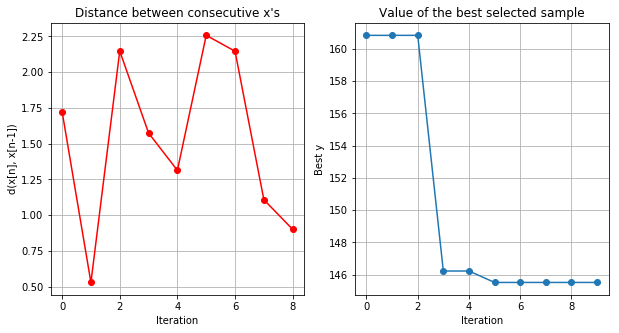

In [11]:
bo.plot_convergence()

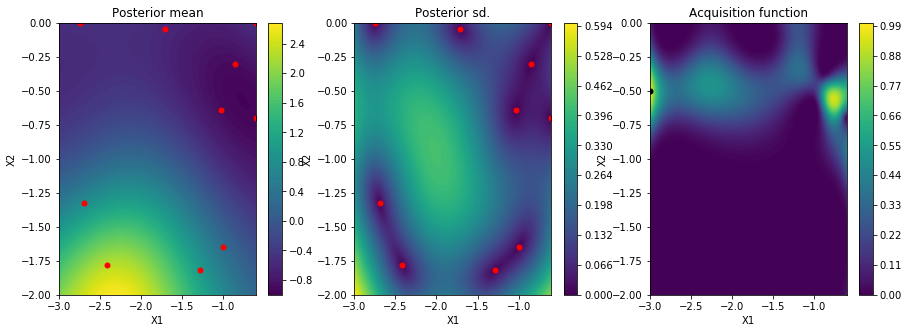

In [12]:
bo.plot_acquisition()

In [13]:
emp_list = list(bo.best_estimator_.covariance_)
alpha = bo.best_params_['alpha']
tau = bo.best_params_['tau']
print(tau) #0.25
print(alpha)# 0.05

0.25
0.200148027652


In [44]:
ll = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=False, verbose=0, rtol=1e-5, tol=1e-5, max_iter=500,
    rho=1. / np.array(data_list).shape[1], eta=0, beta=0, tau=tau, alpha=0.1).fit(data_grid[:500])

In [15]:
ll.score(data_grid[:500])

-137.40166274928077

In [17]:
# ltgl.cv_results_

In [18]:
# reload(latent_time_graph_lasso_v3_)
# emp_cov = [empirical_covariance(a, assume_centered=1) for a in data_list]
# results_time = latent_time_graph_lasso_v3_.latent_time_graph_lasso(
#         emp_cov, alpha=alpha, tau=tau,
#         beta=0, eta=0,
#         tol=1e-6, rtol=1e-6, rho=1. / np.sqrt(np.array(data_list).shape[1]),
#         verbose=1, max_iter=1000)

In [22]:
#print np.linalg.matrix_rank(results_time[1][0])
#print(ltgl.best_score_)#results_time[1][0]
from palladio import plotting; reload(plotting);
plotting.score_surfaces_gridsearch(ltgl, indep_vars=['tau','alpha'], plot_errors=1,
                                  zlim=None)

TypeError: score_surfaces_gridsearch() got an unexpected keyword argument 'zlim'

In [268]:
results_time[-1]

50

In [16]:
%%matlab -i emp_list,alpha,beta,tau -o R,S,L,obj,res,iter
%alpha = 0.05;
%beta = 0.25;
opts.continuation = 1; opts.num_continuation = 0;
opts.eta = sqrt(100); opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;

R = cell(1, size(emp_list,3));
S = cell(1, size(emp_list,3));
L = cell(1, size(emp_list,3));
obj = cell(1, size(emp_list,3));
res = cell(1, size(emp_list,3));
iter = cell(1, size(emp_list,3));
for i=1:size(emp_list,3)
cov = emp_list{i};
    n = size(cov,1);opts.mu = n;
    tic; out_B = ADMM_B(cov,alpha,tau,opts); solve_B = toc;
    %%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);
    R{i} = out_B.R;
    S{i} = out_B.S;
    L{i} = out_B.L;
    obj{i} = out_B.obj;
    res{i} = out_B.resid;
    iter{i} = out_B.iter;
end

In [26]:
R

array([[[ 3.49762705,  0.08178453, -0.11003206, ...,  0.00521433,
         -0.01208111, -0.01124417],
        [ 0.08178453,  3.67553913, -0.01635265, ..., -0.01077362,
          0.04209026, -0.01098477],
        [-0.11003206, -0.01635265,  3.92617443, ..., -0.005452  ,
          0.01997072, -0.00824488],
        ..., 
        [ 0.00521433, -0.01077362, -0.005452  , ...,  3.66664086,
          0.01994893, -0.0048852 ],
        [-0.01208111,  0.04209026,  0.01997072, ...,  0.01994893,
          3.72227348,  0.0229203 ],
        [-0.01124417, -0.01098477, -0.00824488, ..., -0.0048852 ,
          0.0229203 ,  3.61006294]]])

In [18]:
R = np.array(R)
L = np.array(L)
R_ar = np.array([R[i*R.shape[1]:(i+1)*R.shape[1]] for i in range(R.shape[0]/R.shape[1])])
L_ar = np.array([L[i*L.shape[1]:(i+1)*L.shape[1]] for i in range(L.shape[0]/L.shape[1])])
K_obs = np.array(Kobs) # K_obs is the matrix of observed samples
K = np.array(K) # K is the real precision matrix
ells = np.array(ells) # the latent matrices

### Error obtained w.r.t. the observed data

In [45]:
error_norm(ll.precision_ - ll.latent_, [K_obs])

3.6613347301684973

In [28]:
error_norm(R, [K_obs])
#print(ells)

75.331419307791407

### Error obtained w.r.t. the real data

In [46]:
print(error_norm(ll.precision_, [K]))
print(error_norm(ll.latent_, [ells]))

26.0172407754
0.815824150422


In [37]:
print(error_norm(R+L, K))
print(error_norm(L, ells))

80.5046803129
10.0722694488


### Error in ranks

In [47]:
ells_estimated = ll.latent_
print [np.linalg.matrix_rank(ells_estimated[i]) for i in range(ells_estimated.shape[0])]
#print [np.linalg.matrix_rank(L[i]) for i in range(ells_estimated.shape[0])]
print np.linalg.matrix_rank(ells[0])

[9]
7


In [ ]:
#es, Q = np.linalg.eigh(ells_estimated[0])

### Error in structure

In [59]:
def structure_error(true, predict):
#     print(predict)
#     print(true)
#     print(np.count_nonzero(predict))
#     print(np.count_nonzero(true))
#     print("________________________________________________________________________________________")
    true[true != 0] = 1
    predict[predict != 0] = 2
#     print(np.diag(predict))
#     print(np.diag(true))
    res = true+predict
#     print(np.diag(res))
    #print(res)
    #print(res==1)
    FN = np.count_nonzero((res==1).astype(int))
    FP = np.count_nonzero((res==2).astype(int))
    TP = np.count_nonzero((res==3).astype(int))
    TN = np.count_nonzero((res==0).astype(int))
    return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN}
for true, predict in zip(K.copy(), ll.precision_.copy()):
    print(structure_error(true, predict))

{'TN': 8208, 'FP': 710, 'FN': 898, 'TP': 184}


In [60]:
print K.shape

(10, 100, 100)


In [ ]:
print K

In [ ]:
print ltgl.best_estimator_.precision_
